# Web Scraping with Selenium

This notebook shows how to use Selenium to scrape data from https://www.bricocenter.it/

We will first install important modules and packages for our Notebook:

*   Selenium
*   Chromium-chromedriver

<a href="https://colab.research.google.com/drive/1_WyM24eXWf-pdcqJKCcsb1pWwnbEWRi8?authuser=2#scrollTo=VYfg3I_fSt6e"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (120 kB/s)
Reading package lists... Done
Reading package lists... Done
Building de

And now we will import some modules on our Notebook


1.   sys: to setup the path of chrome driver
2.   selenium: to emulate the user behaviour
3.   pandas: to work with data
4.   tqdm: to show a progress bar in our notebook
5.   json: to work with json format





In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from tqdm import tqdm_notebook as tqdm
import pandas
import json
import pprint

First we need to set the options for the ghost browser.
The most important is `--headless` because we are in a "cloud" notebook. In our local notebook we can remove the `--headless` option.


In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

`webdriver` is the most important object in Selenium.

With `webdriver` we can start the phantom browser, emulate the user navigation and scrape our data. 

Let’s now create a new instance of google chrome.


```
wd.get("https://www.manomano.it/mobili-da-giardino-2723?page=1")
```

In [ ]:
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.get("https://prodotti.bricocenter.it/default/giardino.html?p=1")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: use options instead of chrome_options
  """Entry point for launching an IPython kernel.


Take a look at the screenshot of our phantom browser.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


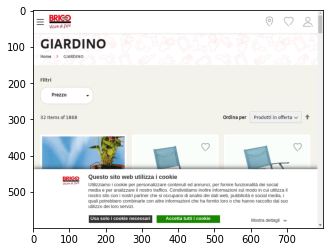

In [ ]:
wd.save_screenshot('screenshot.png')

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/screenshot.png')
imgplot = plt.imshow(img)
plt.show()

Let's try to extract some information from the page.



`title` contains the title of our page.

In [ ]:
print(wd.title)

GIARDINO


# Project List from Bricocenter

Let's begin downloading the list of items.

The list of items is defined by the css selection rule
`#search-snowplow a.js-product-click`



In [ ]:
list_items = wd.find_elements_by_css_selector(".products ol .item")
print(len(list_items))

32


Gread! We find 32 items!

Now, we will extract the attribute from each single element.
The scope is to create one dict for each item.

In [ ]:
import pprint
detail_items = []
for item in list_items:
    title = item.find_elements_by_css_selector(".product-item-link")[0].text
    url = item.find_elements_by_css_selector(".product-item-link")[0].get_attribute("href")
    item_id = item.find_elements_by_css_selector(".price-box")[0].get_attribute("data-product-id")

    detail_items.append({'title': title,
                         'url': url,
                         'item_id': item_id})

print(len(detail_items))
print('---------------------------------------------')
pprint.pprint(detail_items)

32
---------------------------------------------
[{'item_id': '15421',
  'title': 'IRRIGATORE DA BOTTIGLIA IN TERRACOTTA CON TUBICINO PER VASO 4 '
           'PEZZI GEOLIA',
  'url': 'https://prodotti.bricocenter.it/default/catalog/product/view/id/15421/s/500400123-irrigatore-da-bottiglia-in-terracotta-con-tubicino-per-vaso-4-pezzi-geolia/category/765/'},
 {'item_id': '1680',
  'title': 'SEDIA EMYS ORIGAMI BLU',
  'url': 'https://prodotti.bricocenter.it/default/500009652-sedia-emys-origami-blu.html'},
 {'item_id': '1467',
  'title': 'SEDIA EMYS ORIGAMI CON BRACIOLI BLU',
  'url': 'https://prodotti.bricocenter.it/default/500009655-sedia-emys-origami-con-bracioli-blu.html'},
 {'item_id': '1458',
  'title': 'SEDIA EMYS ORIGAMI CON BRACIOLI COCKTAIL',
  'url': 'https://prodotti.bricocenter.it/default/500009657-sedia-emys-origami-con-bracioli-cocktail.html'},
 {'item_id': '1445',
  'title': 'SEDIA EMYS ORIGAMI CON BRACIOLI VERDE',
  'url': 'https://prodotti.bricocenter.it/default/500009656-

Let's now define a `parse_item` function in order to make the code cleaner and reuse that.

In [ ]:
def parse_item(item):
  item_id = ""
  title = ""
  url = ""
  try:
    title = item.find_elements_by_css_selector(".product-item-link")[0].text
    url = item.find_elements_by_css_selector(".product-item-link")[0].get_attribute("href")
    item_id = item.find_elements_by_css_selector(".price-box")[0].get_attribute("data-product-id")
  except:
    pass
  return {'url': url,
          'title': title,
          'item_id': item_id}


Here's how to download the first two pages of projects...

In [ ]:
detail_items = []
for num in tqdm(range(1,3)):
  wd.get(f"https://prodotti.bricocenter.it/default/giardino.html?p={num}")
  wd.save_screenshot(f'screenshot_{num}.png')
  list_items = wd.find_elements_by_css_selector(".products ol .item")
  for item in list_items:
    detail_items.append(parse_item(item))

print(len(detail_items))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



64


In [ ]:
import time
detail_items = []
for num in tqdm(range(1,31)):
  time.sleep(1)
  wd.get(f"https://prodotti.bricocenter.it/default/giardino.html?p={num}")
  list_items = wd.find_elements_by_css_selector(".products ol .item")
  for item in list_items:
    detail_items.append(parse_item(item))

print(len(detail_items))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



960


# Pandas and data processing

We start creating a `DataFrame` using the `pd.DataFrame` method by passing our dictionary as an input parameter.

A `DataFrame` in pandas can be easily exported in whatever kind of format.


In [ ]:
import pandas as pd
ds_detail_items = pd.DataFrame(detail_items)
ds_detail_items.set_index("item_id")
ds_detail_items.head()

,url,title,item_id
0,https://prodotti.bricocenter.it/default/catalo...,IRRIGATORE DA BOTTIGLIA IN TERRACOTTA CON TUBI...,15421
1,https://prodotti.bricocenter.it/default/500009...,SEDIA EMYS ORIGAMI BLU,1680
2,https://prodotti.bricocenter.it/default/500009...,SEDIA EMYS ORIGAMI CON BRACIOLI BLU,1467
3,https://prodotti.bricocenter.it/default/500009...,SEDIA EMYS ORIGAMI CON BRACIOLI COCKTAIL,1458
4,https://prodotti.bricocenter.it/default/500009...,SEDIA EMYS ORIGAMI CON BRACIOLI VERDE,1445


The `.info()` method provides an indication of the structure and data of the `DataFrame`.

In [ ]:
ds_detail_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      960 non-null    object
 1   title    960 non-null    object
 2   item_id  960 non-null    object
dtypes: object(3)
memory usage: 22.6+ KB


In [ ]:
ds_detail_items.to_csv('ds_items.csv')
print(len(ds_detail_items))

960


# Bricocenter item pages ###

Now, the goal is to navigate and download the details of each item.

**Pandas** provides the *.read_csv* method that allows you to upload in CSV format files within a DataFrame.

In [ ]:
# open csv file
import pandas as pd
ds_detail_items = pd.read_csv("ds_items.csv", index_col="item_id")
ds_detail_items.head()

,Unnamed: 0,url,title
item_id,,,
15421,0,https://prodotti.bricocenter.it/default/catalo...,IRRIGATORE DA BOTTIGLIA IN TERRACOTTA CON TUBI...
1680,1,https://prodotti.bricocenter.it/default/500009...,SEDIA EMYS ORIGAMI BLU
1467,2,https://prodotti.bricocenter.it/default/500009...,SEDIA EMYS ORIGAMI CON BRACIOLI BLU
1458,3,https://prodotti.bricocenter.it/default/500009...,SEDIA EMYS ORIGAMI CON BRACIOLI COCKTAIL
1445,4,https://prodotti.bricocenter.it/default/500009...,SEDIA EMYS ORIGAMI CON BRACIOLI VERDE


Let's try downloading the whole bunch of items.

In [ ]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import json as js

details = []
for item_id, item in ds_detail_items.head(1000).iterrows():
    time.sleep(1)
    link = item["url"]
    print(link)
    try:
      wd.get(link)
      wd.set_window_size(1920, 1080)
      wd.execute_script("window.scrollTo(0, 1000)") 
      wd.find_element_by_id("tab-label-additional-title").click()

      ean = wd.find_elements_by_css_selector("[data-th='EAN']")[0].text    
      price = wd.find_elements_by_css_selector(".product-info-price .price")[0].text
      title = wd.find_element_by_css_selector("div.page-title-wrapper.product > h1 > span").text

      details.append({'item_id': item_id,
                      'title': title,
                      'price': price,
                      'ean': ean})
         
    except Exception as e:
      print(e)

pprint.pprint(details)

https://prodotti.bricocenter.it/default/catalog/product/view/id/15421/s/500400123-irrigatore-da-bottiglia-in-terracotta-con-tubicino-per-vaso-4-pezzi-geolia/category/765/
https://prodotti.bricocenter.it/default/500009652-sedia-emys-origami-blu.html
https://prodotti.bricocenter.it/default/500009655-sedia-emys-origami-con-bracioli-blu.html
https://prodotti.bricocenter.it/default/500009657-sedia-emys-origami-con-bracioli-cocktail.html
https://prodotti.bricocenter.it/default/500009656-sedia-emys-origami-con-bracioli-verde.html
https://prodotti.bricocenter.it/default/500009654-sedia-emys-origami-cocktail.html
https://prodotti.bricocenter.it/default/500009653-sedia-emys-origami-verde.html
https://prodotti.bricocenter.it/default/500007829-carriola-in-plastica-50lt-con-manico.html
https://prodotti.bricocenter.it/default/500410069-programmatore-a-1-via-jardibric.html
https://prodotti.bricocenter.it/default/500008140-sedia-da-giardino-richiudibile-in-metallo.html
https://prodotti.bricocenter.it/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
len(details)

958

Store the data with *pandas*

In [ ]:
import pandas as pd
ds_details = pd.DataFrame(details)
ds_details.set_index("item_id")
ds_details.head()

,item_id,title,price,ean
0,15421,IRRIGATORE DA BOTTIGLIA IN TERRACOTTA CON TUBI...,"€ 3,70",3351841980837
1,1680,SEDIA EMYS ORIGAMI BLU,"€ 19,00",3276000400639
2,1467,SEDIA EMYS ORIGAMI CON BRACIOLI BLU,"€ 26,00",3276000400684
3,1458,SEDIA EMYS ORIGAMI CON BRACIOLI COCKTAIL,"€ 26,00",3276000400721
4,1445,SEDIA EMYS ORIGAMI CON BRACIOLI VERDE,"€ 26,00",3276000400707


In [ ]:
ds_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_id  958 non-null    int64 
 1   title    958 non-null    object
 2   price    958 non-null    object
 3   ean      958 non-null    object
dtypes: int64(1), object(3)
memory usage: 30.1+ KB


In [ ]:
ds_details.to_csv("ds_item_details_Bricocenter.csv")

Congrats! Job done.